In [1]:
import numpy as np
seed = 71
np.random.seed = seed

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

algorithm_globals.random_seed = seed

In [2]:
# Number training data samples
N = 1000

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean=mu, sigma=sigma, size=N)
# print(real_data)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0., 7.])
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [6]
k = len(num_qubits)

In [3]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 10
# Batch size
batch_size = 100

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'),
                                   seed_transpiler=seed, seed_simulator=seed)

# Set entangler map
entangler_map = [[0, 1]]

# Set an initial state for the generator circuit
init_dist = UniformDistribution(sum(num_qubits))

# Set the ansatz circuit
ansatz = TwoLocal(int(np.sum(num_qubits)), 'ry', 'cz', 'circular', reps=1, insert_barriers=True)
print(ansatz)

# Set generator's initial parameters - in order to reduce the training time and hence the
# total running time for this notebook
#init_params = [3., 1., 0.6, 1.6]

# You can increase the number of training epochs and use random initial parameters.
init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi

# Set generator circuit by adding the initial distribution infront of the ansatz
g_circuit = ansatz.compose(init_dist, front=True)
print(g_circuit)

# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

     ┌──────────┐ ░                    ░  ┌──────────┐
q_0: ┤ Ry(θ[0]) ├─░──■──■──────────────░──┤ Ry(θ[6]) ├
     ├──────────┤ ░  │  │              ░  ├──────────┤
q_1: ┤ Ry(θ[1]) ├─░──┼──■──■───────────░──┤ Ry(θ[7]) ├
     ├──────────┤ ░  │     │           ░  ├──────────┤
q_2: ┤ Ry(θ[2]) ├─░──┼─────■──■────────░──┤ Ry(θ[8]) ├
     ├──────────┤ ░  │        │        ░  ├──────────┤
q_3: ┤ Ry(θ[3]) ├─░──┼────────■──■─────░──┤ Ry(θ[9]) ├
     ├──────────┤ ░  │           │     ░ ┌┴──────────┤
q_4: ┤ Ry(θ[4]) ├─░──┼───────────■──■──░─┤ Ry(θ[10]) ├
     ├──────────┤ ░  │              │  ░ ├───────────┤
q_5: ┤ Ry(θ[5]) ├─░──■──────────────■──░─┤ Ry(θ[11]) ├
     └──────────┘ ░                    ░ └───────────┘
     ┌───┐┌──────────┐ ░                    ░  ┌──────────┐
q_0: ┤ H ├┤ Ry(θ[0]) ├─░──■──■──────────────░──┤ Ry(θ[6]) ├
     ├───┤├──────────┤ ░  │  │              ░  ├──────────┤
q_1: ┤ H ├┤ Ry(θ[1]) ├─░──┼──■──■───────────░──┤ Ry(θ[7]) ├
     ├───┤├──────────┤ ░  │     │           ░

<ipython-input-3-e5714629aca4>:18: DeprecationWarning: `UniformDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.UniformDistribution.
  init_dist = UniformDistribution(sum(num_qubits))


In [4]:
# Run qGAN
result = qgan.run(quantum_instance)

In [5]:
print('Training results:')
for key, value in result.items():
    print(f'  {key} : {value}')

Training results:
  params_d : [ 0.04129953  0.60559858 -0.47431268 ... -0.16199578 -0.20629766
 -0.08625186]
  params_g : [5.49769695 2.35992124 0.94000833 0.34830014 2.35274786 1.49540285
 0.52402739 4.56541788 0.03647889 3.79773494 1.07736198 5.45643698]
  loss_d : 0.6848
  loss_g : [0.6075]
  rel_entr : 1.9135


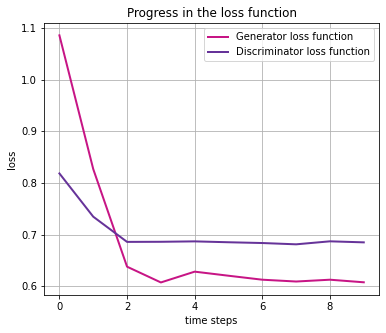

In [6]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label='Generator loss function', color='mediumvioletred', linewidth=2)
plt.plot(t_steps, qgan.d_loss, label='Discriminator loss function', color='rebeccapurple', linewidth=2)
plt.grid()
plt.legend(loc='best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()

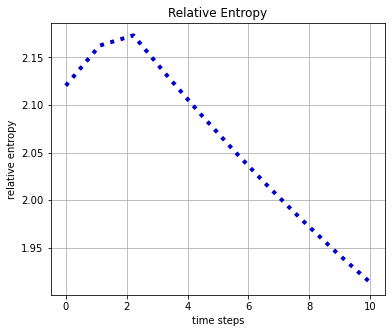

In [7]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

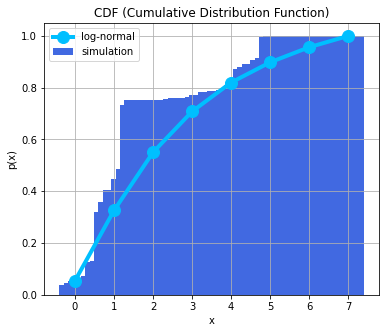

In [8]:
#Plot the CDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title('CDF (Cumulative Distribution Function)')
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()